# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="./Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

### Agent Network ###

```
Actor(
  (fc1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
)
Critic(
  (fcs1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=258, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)
```

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

#Actor and Critic Networks
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.elu(self.fc1(state))
        x = F.elu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.elu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.elu(self.fc2(x))
        return self.fc3(x)

### DDPG Agent ###

ddpg agent with code similar to continuous comtrol project. Rather than being a true multi agent code. This agent uses a replay buffer which is udpated by multiple agents. 

There is a global actor and critic, which use data from all agents to train. Additional learning without, updates to target actor and critic networks, help the agent converge faster. 

In [6]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn.functional as F
import torch.optim as optim

#Hyper parameters
BUFFER_SIZE = int(1e5)    # replay buffer size
BATCH_SIZE = 128          # minibatch size
GAMMA = 0.99              # discount factor
TAU = 1e-3                # for soft update of target parameters
ACTOR_LR = 1e-4           # learning rate of actor 
CRITIC_LR = 1e-4          # learning rate of critic
ACTOR_WEIGHT_DECAY = 0.0  # L2 weight decay of actor
CRITIC_WEIGHT_DECAY = 0.0 # L2 weight decay of critic

class Agent():
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)

        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=ACTOR_LR, weight_decay=ACTOR_WEIGHT_DECAY)

        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=CRITIC_LR, weight_decay=CRITIC_WEIGHT_DECAY)

        self.noise = OUNoise((num_agents, action_size), random_seed) 

        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        
        # for every agent add to the replay buffer
        for index in range(self.num_agents):
            self.memory.add(states[index], actions[index], rewards[index], next_states[index], dones[index])

        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def act(self, states, add_noise=True):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            actions = self.actor_local(states).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise:
            actions += self.noise.sample()

        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        
        #clip the gradient for the critic as per udacity recommendation
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1.0) 
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


### Initialize a ddpg agent ###

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

agent = Agent(state_size, action_size, num_agents, 0)

### Train multiple ddpg agents, contributing to the global replay buffer, to train a universal agent with a single actor, critic model ###

In [8]:
import signal

from contextlib import contextmanager

import requests


DELAY = INTERVAL = 4 * 60  # interval time in seconds
MIN_DELAY = MIN_INTERVAL = 2 * 60
KEEPALIVE_URL = "https://nebula.udacity.com/api/v1/remote/keep-alive"
TOKEN_URL = "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token"
TOKEN_HEADERS = {"Metadata-Flavor":"Google"}


def _request_handler(headers):
    def _handler(signum, frame):
        requests.request("POST", KEEPALIVE_URL, headers=headers)
    return _handler


@contextmanager
def active_session(delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import active session

    with active_session():
        # do long-running work here
    """
    token = requests.request("GET", TOKEN_URL, headers=TOKEN_HEADERS).text
    headers = {'Authorization': "STAR " + token}
    delay = max(delay, MIN_DELAY)
    interval = max(interval, MIN_INTERVAL)
    original_handler = signal.getsignal(signal.SIGALRM)
    try:
        signal.signal(signal.SIGALRM, _request_handler(headers))
        signal.setitimer(signal.ITIMER_REAL, delay, interval)
        yield
    finally:
        signal.signal(signal.SIGALRM, original_handler)
        signal.setitimer(signal.ITIMER_REAL, 0)


def keep_awake(iterable, delay=DELAY, interval=INTERVAL):
    """
    Example:

    from workspace_utils import keep_awake

    for i in keep_awake(range(5)):
        # do iteration with lots of work here
    """
    with active_session(delay, interval): yield from iterable
        
def multi_ddpg(n_episodes=1000):
    scores_deque = deque(maxlen=100)
    collected_scores = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     
        states = env_info.vector_observations                   
        agent.reset() 
        scores = np.zeros(num_agents)                          
        
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done                        
            scores += rewards                                  
            agent.step(states, actions, rewards, next_states, dones) 
            
            # do extra learning
            if len(agent.memory) > BATCH_SIZE:
                for _ in range(3):
                    experiences = agent.memory.sample()
                    agent.learn(experiences, GAMMA)
            
            states = next_states                               
            if np.any(dones):                                  
                break
        
        scores = np.max(scores)
        scores_deque.append(np.mean(scores))
        collected_scores.append(np.mean(scores))
        
        print('\rEpisode {} \tAverage Score: {:.2f} \t Score: {}'.format(i_episode, np.mean(scores_deque), np.mean(scores)), end="")
        
        if i_episode % 100 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {} \tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return collected_scores

In [ ]:
scores = multi_ddpg(n_episodes=2500)

Episode 100 	Average Score: 0.00 	 Score: 0.000000149011612
Episode 200 	Average Score: 0.00 	 Score: 0.00000000298023224
Episode 300 	Average Score: 0.02 	 Score: 0.10000000149011612
Episode 400 	Average Score: 0.03 	 Score: 0.00000000149011612
Episode 500 	Average Score: 0.06 	 Score: 0.10000000149011612
Episode 600 	Average Score: 0.13 	 Score: 0.10000000149011612
Episode 700 	Average Score: 0.21 	 Score: 0.20000000298023224
Episode 800 	Average Score: 0.35 	 Score: 1.50000002235174186
Episode 900 	Average Score: 0.46 	 Score: 0.10000000149011612
Episode 1000 	Average Score: 0.63 	 Score: 0.5000000074505806
Episode 1100 	Average Score: 1.00 	 Score: 0.80000001192092914
Episode 1200 	Average Score: 0.72 	 Score: 0.19000000506639482
Episode 1300 	Average Score: 0.73 	 Score: 1.00000001490116126
Episode 1400 	Average Score: 0.68 	 Score: 0.60000000894069676
Episode 1500 	Average Score: 0.61 	 Score: 1.50000002235174184
Episode 1600 	Average Score: 0.53 	 Score: 0.20000000298023224
Epis

### Plot of agent performance during training. Agent manages to get +.5 avg reward over 100 episodes on multiple occasions ###

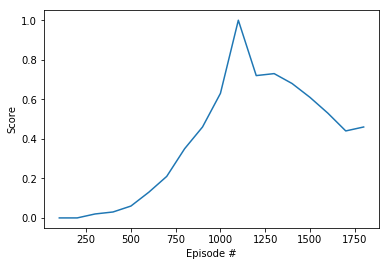

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

episodes = [x * 100 for x in range(1, len(scores) + 1)]
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(episodes, scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Prepare agent for inference ###

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent = Agent(state_size=env_info.vector_observations.shape[1], action_size=brain.vector_action_space_size, 
              num_agents=env_info.vector_observations.shape[0],  random_seed=0)

### Load saved agent weights ###

In [8]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth', map_location=lambda storage, loc: storage))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth', map_location=lambda storage, loc: storage))

### Run inference using the saved agent ###

In [14]:
import matplotlib.pyplot as plt

def multi_ddpg_inference(n_episodes=100):
    result = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=False)[brain_name]    
        states = env_info.vector_observations                   
        agent.reset() 
        scores = np.zeros(num_agents)    
        
        while True:
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           
            next_states = env_info.vector_observations         
            rewards = env_info.rewards                         
            dones = env_info.local_done                        
            scores += rewards                                  
            states = next_states            
            
            if np.any(dones):                                  
                break
                
        print('\r Episode {}: {}'.format(i_episode, np.max(scores), end=""))
        result.append(np.max(scores))
        
    print('Mean score is: ', np.mean(np.array(result)))
    return result

In [15]:
scores = multi_ddpg_inference()

 Episode 1: 0.6000000089406967
 Episode 2: 0.6000000089406967
 Episode 3: 0.30000000447034836
 Episode 4: 0.20000000298023224
 Episode 5: 0.4000000059604645
 Episode 6: 0.20000000298023224
 Episode 7: 0.10000000149011612
 Episode 8: 0.10000000149011612
 Episode 9: 0.10000000149011612
 Episode 10: 0.20000000298023224
 Episode 11: 0.0
 Episode 12: 0.30000000447034836
 Episode 13: 0.4000000059604645
 Episode 14: 0.0
 Episode 15: 1.600000023841858
 Episode 16: 0.49000000953674316
 Episode 17: 1.2000000178813934
 Episode 18: 0.20000000298023224
 Episode 19: 0.20000000298023224
 Episode 20: 0.10000000149011612
 Episode 21: 0.0
 Episode 22: 0.0
 Episode 23: 0.10000000149011612
 Episode 24: 0.10000000149011612
 Episode 25: 0.5000000074505806
 Episode 26: 0.5000000074505806
 Episode 27: 0.6000000089406967
 Episode 28: 0.5000000074505806
 Episode 29: 0.2900000046938658
 Episode 30: 0.10000000149011612
 Episode 31: 0.0
 Episode 32: 0.30000000447034836
 Episode 33: 0.0
 Episode 34: 0.1000000014901

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [8]:
env.close()